In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

_display_plot_rcParams = {
    "figure.figsize": [10, 7],
    "figure.dpi": 100,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": True,
    "font.size": 12,
    "mathtext.default": "regular",
    "font.family": "DejaVu Serif",
}
matplotlib.rcParams.update(_display_plot_rcParams)

import h5py

with h5py.File("../data/results/hv_lightmap.h5", "r") as f:
    positions = np.array(list(zip(f["posX"], f["posY"], f["posZ"])))  
    pte = np.array([f[f"ch{i:02d}_pte"] for i in range(2)]).T

In [8]:
mins

[5.0, 5.0, 5.0]

In [121]:
# shift positions to the center
positions[:,2] -= (positions[:, 2].max() + positions[:, 2].min()) / 2
positions[:,0] -= (positions[:, 0].max() + positions[:, 0].min()) / 2

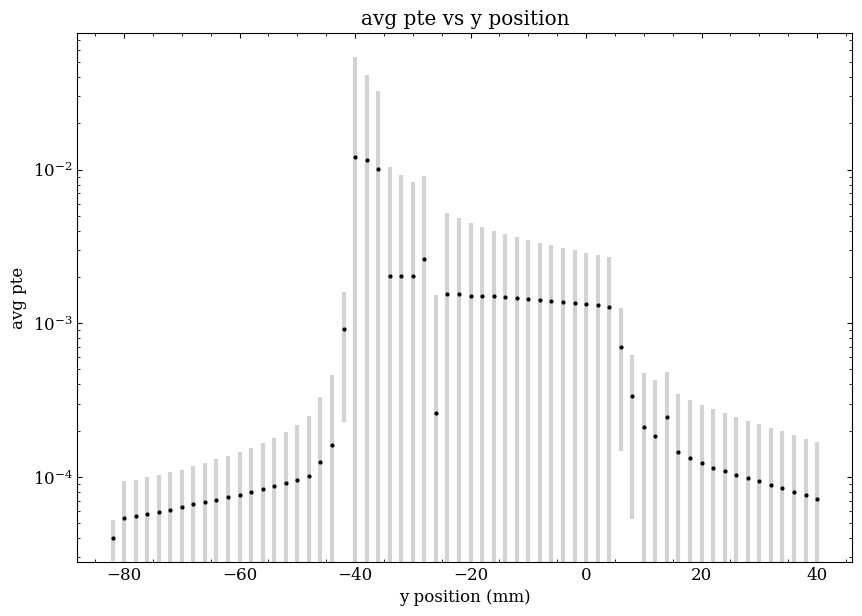

In [24]:
unique_y = np.unique(positions[:, 1])
# get avg pte for each y
avg_pte = []
std_pte = []
for y in unique_y:
    avg_pte.append(np.mean(pte[positions[:, 1] == y]))
    std_pte.append(np.std(pte[positions[:, 1] == y]))
    
# plot avg pte vs y
import matplotlib.pyplot as plt
plt.errorbar(unique_y, avg_pte, yerr=std_pte, fmt='o', color='black', ecolor='lightgrey', elinewidth=3, capsize=0, ms=2)
plt.xlabel("y position (mm)")
plt.ylabel("avg pte")
plt.yscale("log")
plt.title("avg pte vs y position")
plt.show()


In [5]:
pte[pte <= 0] = pte[pte > 0].min()

In [6]:
det = d['detected']

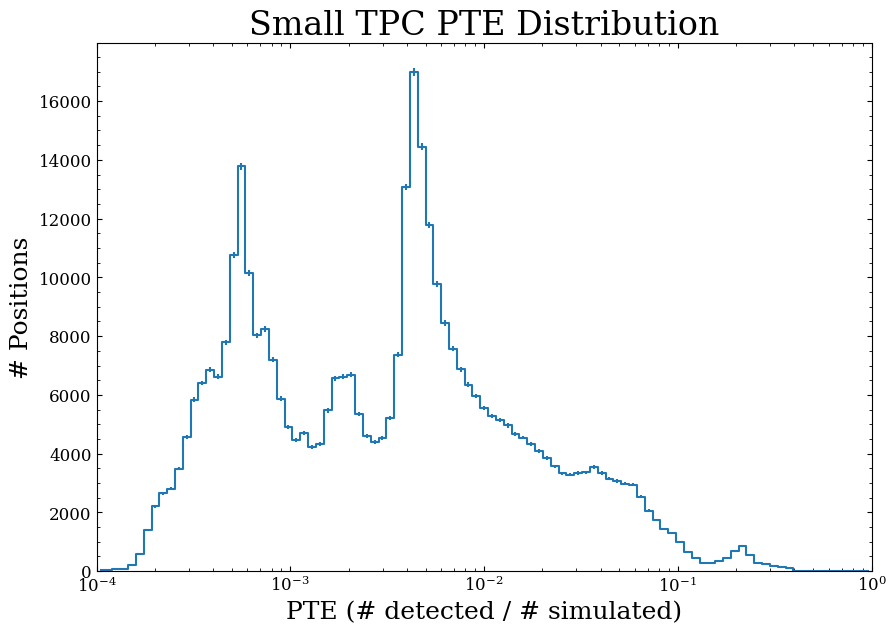

In [7]:
# plt.hist(pte,bins=np.logspace(-4, 0, 100), density=True, histtype='step')


bins = np.logspace(-4, 0, 100)
counts, edges = np.histogram(pte, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2
errors = np.sqrt(det / 1e6)

bin_error = np.zeros(len(counts))
for i in range(len(counts)):
    indices = np.where((pte > edges[i]) & (pte < edges[i+1]))[0]
    bin_error[i] = np.sqrt(np.sum(errors[indices]**2)) / (len(indices) if len(indices) > 0 else 1)

plt.errorbar(centers, counts, yerr=counts**0.5, drawstyle='steps-mid')
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("PTE (# detected / # simulated)", fontsize=18)
plt.ylabel("# Positions", fontsize=18)
plt.ylim(0,)
plt.xlim(1e-4,1e0)
plt.title("Small TPC PTE Distribution", fontsize=24)
plt.savefig("pte_dist.png", dpi=300)
plt.show()

In [122]:
import trimesh

# color based on pte
color = np.zeros((len(pte), 4))
color[:, 3] = 1
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

map = cm.viridis
pte[pte<=1e-4] = 1e-4
ax = (pte - float(pte.min())) / (float(pte.max()) - float(pte.min()))
ax_log = LogNorm()(ax)

frgba = (map(ax_log) * 255).astype(int)

mesh = trimesh.PointCloud(
    positions, colors=frgba
)

ValueError: Colors not of appropriate shape!

In [9]:
tiles = !ls ../data/stl/sipm_tiles/*.STL

tile_meshes = []
for tile in tiles:
    m = trimesh.load(tile)
    # set to gold
    m.visual.face_colors = [255, 255, 0, 128]
    tile_meshes.append(m)


In [19]:
assembly = trimesh.load_mesh("../data/stl/short_tpc_assembly_modulo_anode_sipm.STL")
# set face colors to transparent grey
assembly.visual.face_colors = [128, 128, 128, 128]


In [ ]:
trimesh.Scene([assembly, mesh]).show(line_settings={"point_size": 100})

In [10]:
from tqdm import tqdm

unique_y = np.unique(positions[:, 1])

points = []
for y in tqdm(unique_y):
    indices = np.where(positions[:, 1] == y)[0]
    
    pos = positions[indices]
    r = np.linalg.norm(pos[:, [0,2]], axis=1)
    # get unique r
    unique_r = np.unique(r)
    # get avg pte for each r
    for r_ in unique_r:
        points.append([r_, y, np.mean(pte[indices][r == r_])])    

100%|██████████| 62/62 [00:26<00:00,  2.35it/s]


In [11]:
points[:, 2].max()

TypeError: list indices must be integers or slices, not tuple

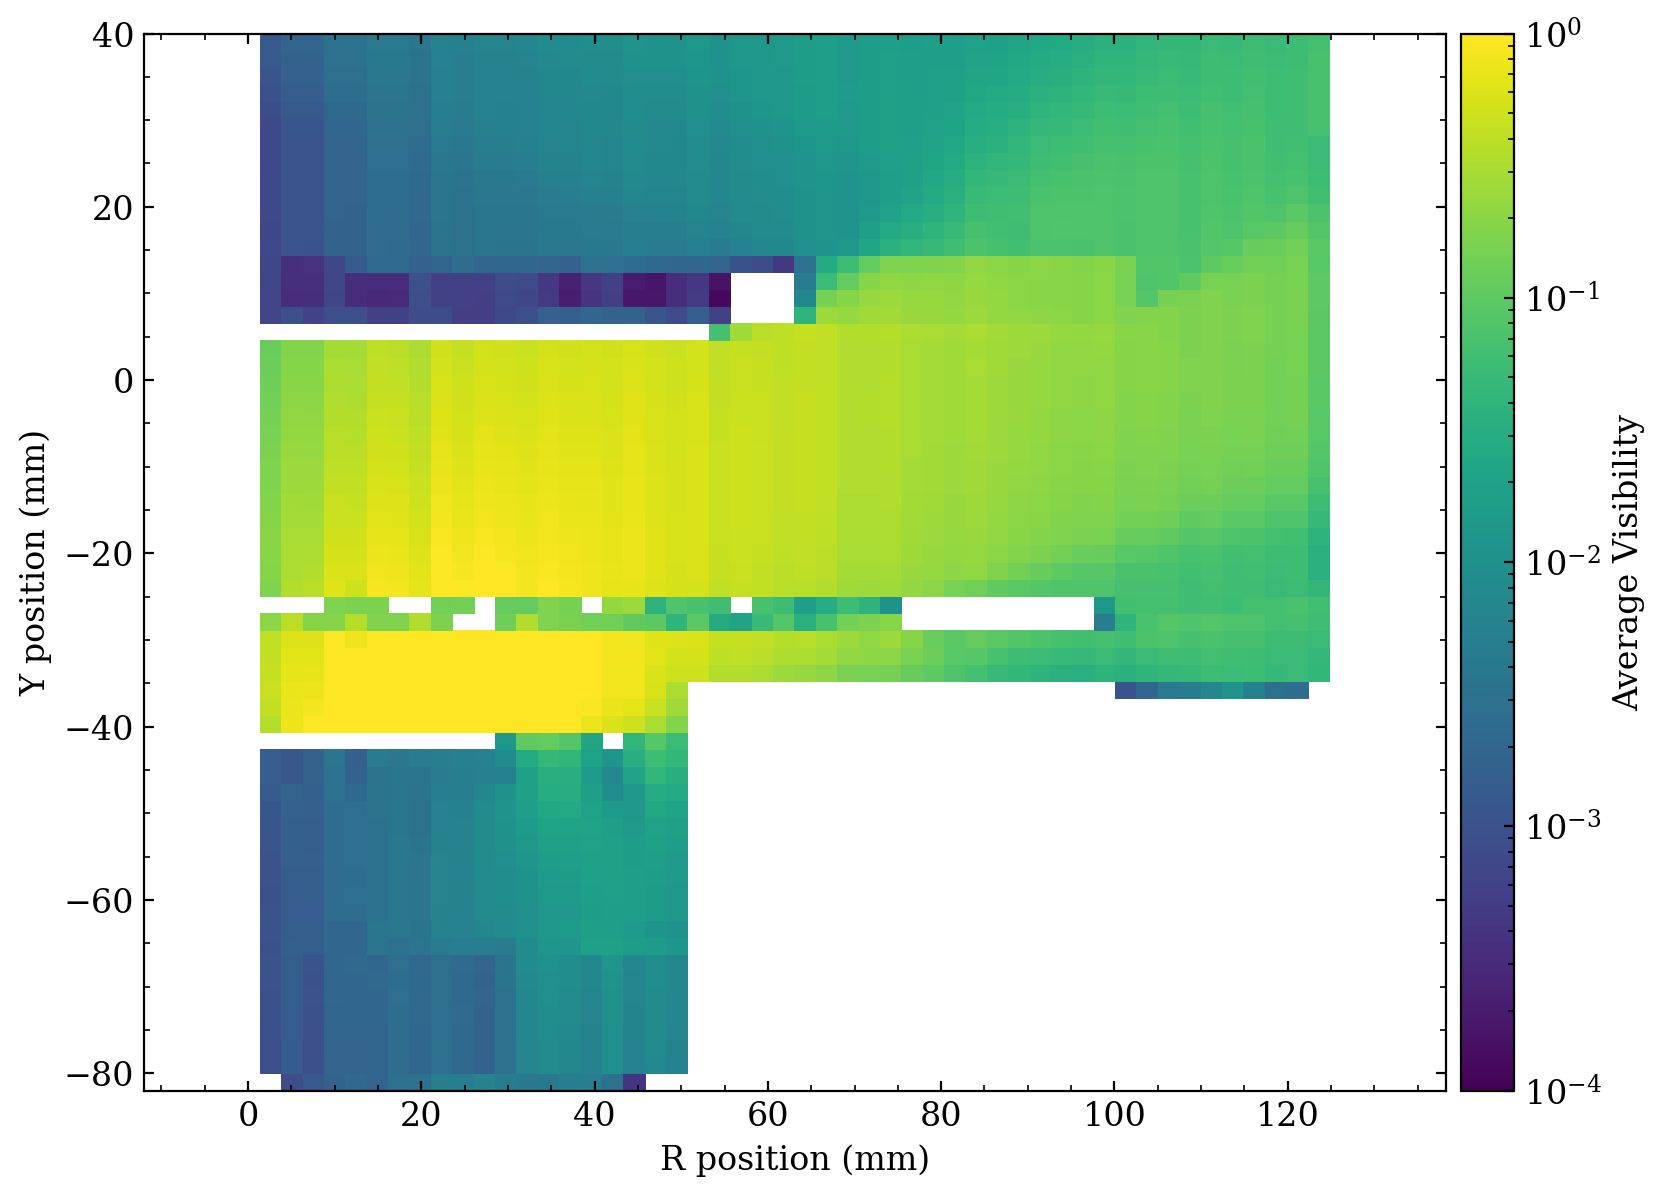

In [20]:
# 2d histogram of r vs y with pte as color
points = np.array(points)
plt.figure(figsize=(10, 7), dpi=200)
plt.hist2d(points[:,0], points[:,1], bins=(50, len(unique_y)), weights=points[:,2], norm=LogNorm(vmin=1e-4, vmax=1e0))
plt.xlabel("R position (mm)")
plt.ylabel("Y position (mm)")
plt.colorbar(label="Average Visibility", pad=0.01)
plt.axis('equal')
# plt.title("Short TPC MC Light Map")
plt.savefig("short_tpc_radial_light_map.png", dpi=300)
plt.show()
# plt.scatter(points[:, 0], points[:, 1], c=np.log10(points[:, 2]), cmap='viridis')
# plt.colorbar()
# plt.title("PTE vs r and y position")
# plt.show()

In [12]:
from slar.nets import SirenVis


cfg1 = """
photonlib:
    filepath: /home/sam/sw/chroma-lxe/data/lxeplib_2mm.h5
model:
    network:
        in_features: 3
        hidden_features: 512
        hidden_layers: 5
        out_features: 1
    # ckpt_file: "/home/sam/sw/siren-lartpc/logs_noweight/version-00/iteration-011200-epoch-1400.ckpt"
    ckpt_file: "/home/sam/sw/siren-lartpc/logs_weighted/version-01/iteration-004000-epoch-0500.ckpt"
    output_scale:
        fix: True
"""

import yaml

cfg1 = yaml.safe_load(cfg1)

vis_w = SirenVis(cfg1)

cfg2 = """
photonlib:
    filepath: /home/sam/sw/chroma-lxe/data/lxeplib_2mm.h5
model:
    network:
        in_features: 3
        hidden_features: 512
        hidden_layers: 5
        out_features: 1
    ckpt_file: "/home/sam/sw/siren-lartpc/logs_noweight/version-00/iteration-011200-epoch-1400.ckpt"
    output_scale:
        fix: True
"""

import yaml

cfg2 = yaml.safe_load(cfg2)

vis_nw = SirenVis(cfg2)

[Siren] 3 in => 1 out, hidden 512 features 5 layers
        omega 30 first 30.0 hidden, the final layer linear False
[SirenVis] loading model_dict from checkpoint /home/sam/sw/siren-lartpc/logs_weighted/version-01/iteration-004000-epoch-0500.ckpt
[SirenVis] loading model_dict
[SirenVis] loading finished

[Siren] 3 in => 1 out, hidden 512 features 5 layers
        omega 30 first 30.0 hidden, the final layer linear False
[SirenVis] loading model_dict from checkpoint /home/sam/sw/siren-lartpc/logs_noweight/version-00/iteration-011200-epoch-1400.ckpt
[SirenVis] loading model_dict
[SirenVis] loading finished



In [13]:
import torch

t_pos = torch.as_tensor(positions, dtype=torch.float32)

pte_siren_w = vis_w.visibility(t_pos).ravel().detach().cpu().numpy()
pte_siren_nw = vis_nw.visibility(t_pos).ravel().detach().cpu().numpy()

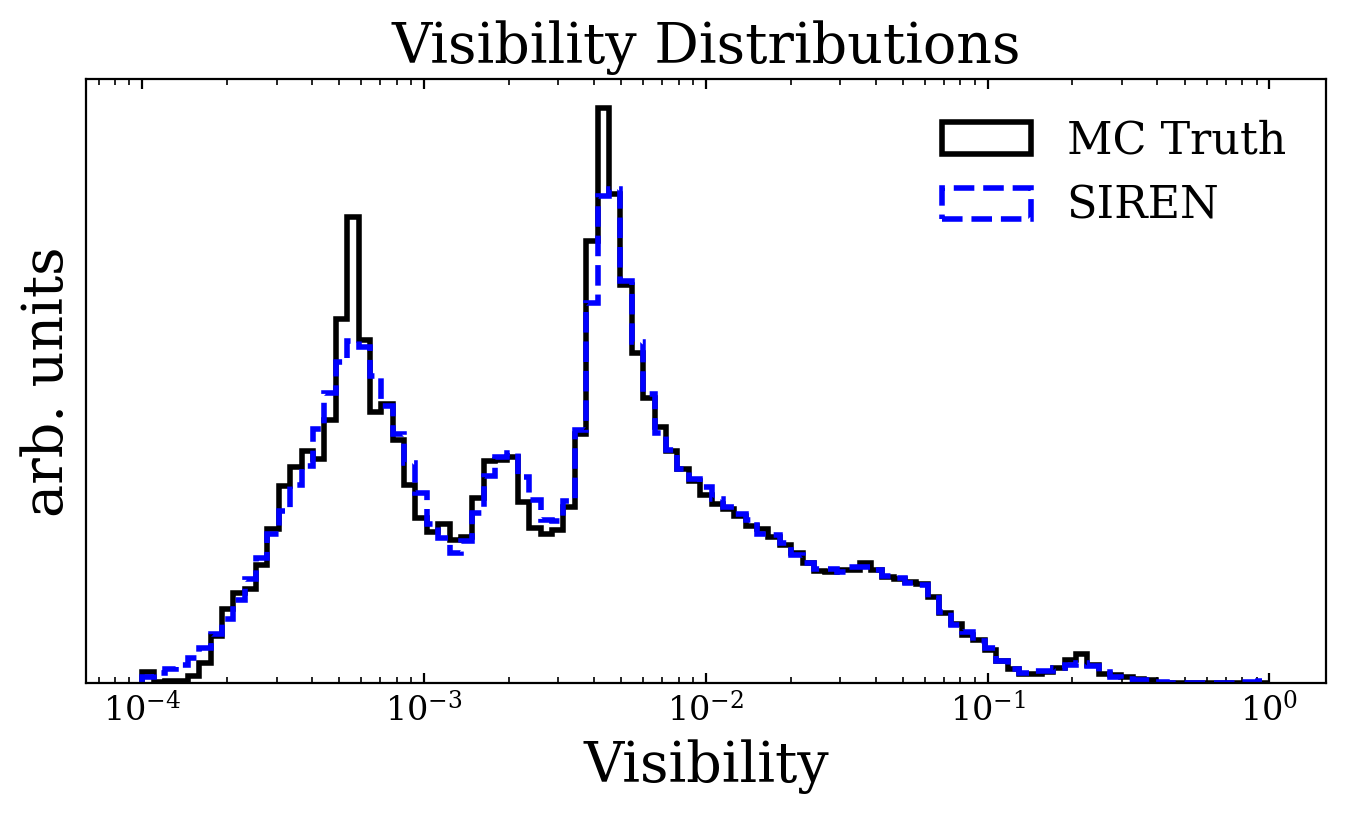

In [22]:
plt.figure(figsize=(8,4), dpi=200)
plt.hist(pte, bins=np.logspace(-4, 0, 100), density=False, histtype='step', label='MC Truth', color='black', linewidth=2)
# plt.hist(pte_siren_nw, bins=np.logspace(-9, 0, 100), density=False, histtype='step', label='SIREN (Unweighted)',
#          color='red', linewidth=2)
plt.hist(pte_siren_w, bins=np.logspace(-4, 0, 100), density=False, histtype='step', label='SIREN',
         color='blue', linestyle='--', linewidth=2)
plt.xscale("log")
plt.legend(frameon=False, loc='upper right', fontsize=16)
# plt.yscale("log")
plt.yticks([])
plt.title("Visibility Distributions", fontsize=20)
plt.ylabel("arb. units", fontsize=20)
plt.xlabel("Visibility", fontsize=20)
plt.ylim(0,None)
plt.show()


In [16]:
unique_y = np.unique(positions[:, 1])

points_siren_w = []
points_siren_nw = []
for y in tqdm(unique_y):
    indices = np.where(positions[:, 1] == y)[0]

    pos = positions[indices]
    r = np.linalg.norm(pos[:, [0, 2]], axis=1)
    # get unique r
    unique_r = np.unique(r)
    # get avg pte for each r
    for r_ in unique_r:
        points_siren_w.append([r_, y, np.mean(pte_siren_w[indices][r == r_])])
        points_siren_nw.append([r_, y, np.mean(pte_siren_nw[indices][r == r_])])

100%|██████████| 62/62 [00:02<00:00, 24.72it/s] 


In [67]:
len(points_siren_w), len(pte)

(40261, 390702)

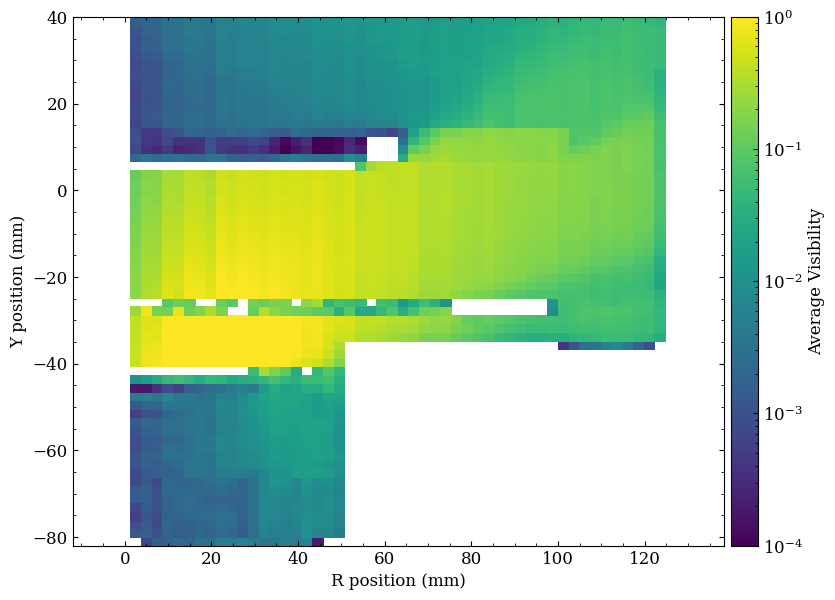

In [21]:
# 2d histogram of r vs y with pte as color
points_siren_w = np.array(points_siren_w)
points_siren_nw = np.array(points_siren_nw)
plt.hist2d(
    points_siren_w[:, 0],
    points_siren_w[:, 1],
    bins=(50, len(unique_y)),
    weights=points_siren_w[:, 2],
    norm=LogNorm(vmin=1e-4, vmax=1e0),
)
plt.xlabel("R position (mm)")
plt.ylabel("Y position (mm)")
plt.colorbar(label="Average Visibility", pad=0.01)
# plt.title("Small TPC SIREN Light Map")
# set equal axis
plt.axis("equal")
plt.savefig("lm_siren_weighted.png", dpi=300)
plt.show()
# plt.scatter(points_siren[:, 0], points_siren[:, 1], c=np.log10(points_siren[:, 2]), cmap='viridis')
# plt.colorbar()
# plt.title("PTE vs r and y position")
# plt.show()

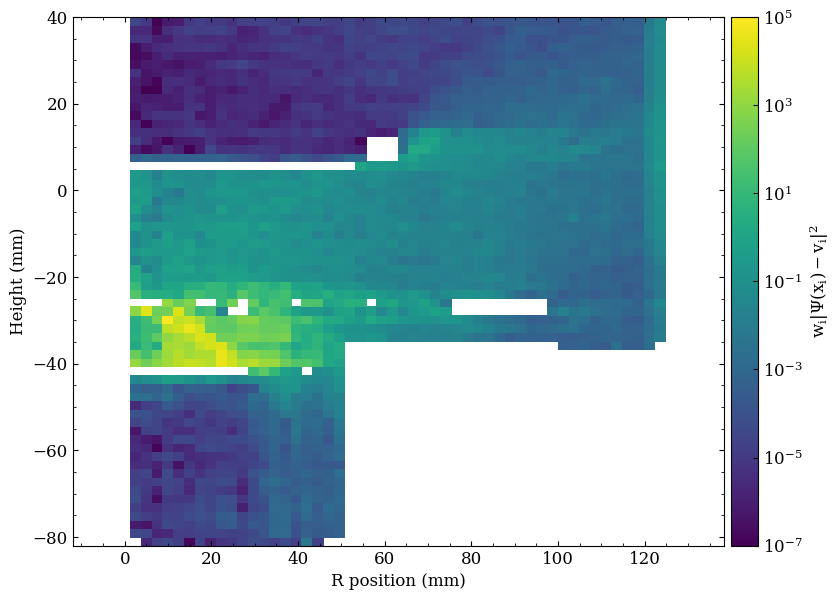

In [38]:
# 2d histogram of r vs y with pte as color
plt.hist2d(
    points_siren_w[:, 0],
    points_siren_w[:, 1],
    bins=(50, len(unique_y)),
    weights=1e6 * points[:, 2] * (points[:, 2] - points_siren_w[:, 2]) ** 2,
    norm=LogNorm(vmin=1e-7, vmax=1e5),
)
plt.xlabel("R position (mm)")
plt.ylabel("Height (mm)")
plt.colorbar(label="$w_i|\\Psi(x_i)-v_i|^2$", pad=0.01)
# plt.title("Small TPC MC v. SIREN Squared Residuals")
# set equal axis
plt.axis("equal")
# plt.savefig("lm_siren_squared_error.png", dpi=300)
plt.show()
# plt.scatter(points_siren[:, 0], points_siren[:, 1], c=np.log10(points_siren[:, 2]), cmap='viridis')
# plt.colorbar()
# plt.title("PTE vs r and y position")
# plt.show()

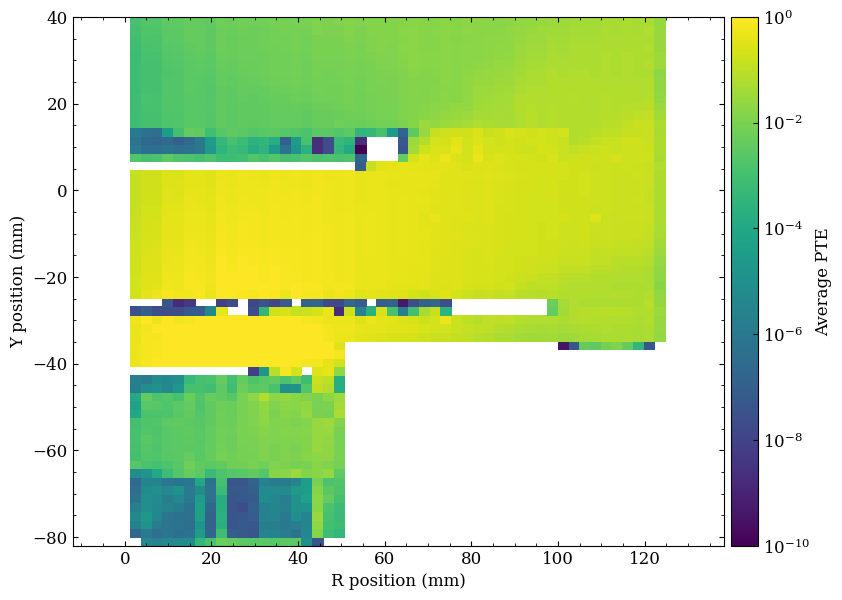

In [112]:
# 2d histogram of r vs y with pte as color
points_siren_nw = np.array(points_siren_nw)
plt.hist2d(
    points_siren_nw[:, 0],
    points_siren_nw[:, 1],
    bins=(50, len(unique_y)),
    weights=points_siren_nw[:, 2],
    norm=LogNorm(vmin=1e-10, vmax=1e0),
)
plt.xlabel("R position (mm)")
plt.ylabel("Y position (mm)")
plt.colorbar(label="Average PTE", pad=0.01)
plt.title("SIREN Light Map (Unweighted)")
# set equal axis
plt.axis("equal")
plt.savefig("lm_siren_unweighted.png", dpi=300)
plt.show()
# plt.scatter(points_siren[:, 0], points_siren[:, 1], c=np.log10(points_siren[:, 2]), cmap='viridis')
# plt.colorbar()
# plt.title("PTE vs r and y position")
# plt.show()

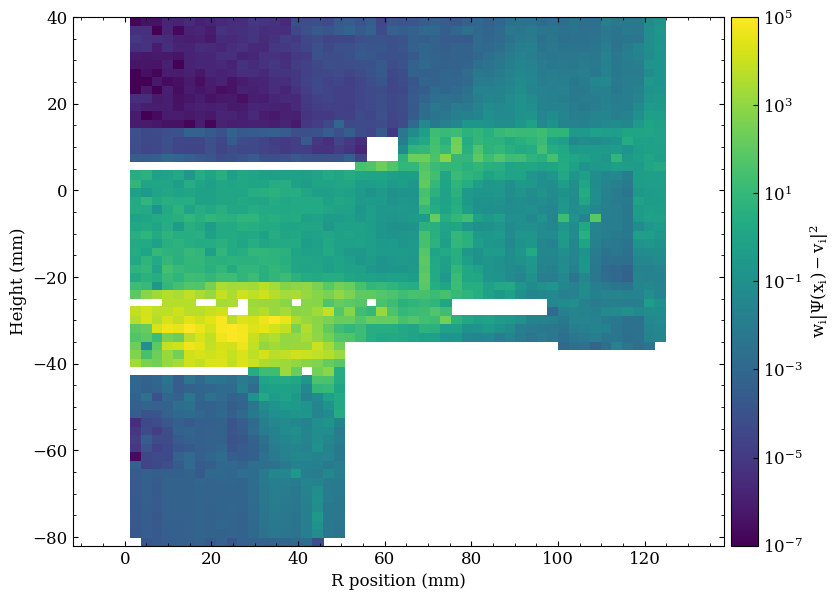

In [39]:
# 2d histogram of r vs y with pte as color
plt.hist2d(
    points_siren_nw[:, 0],
    points_siren_nw[:, 1],
    bins=(50, len(unique_y)),
    weights=1e6 * points[:, 2] * (points[:, 2] - points_siren_nw[:, 2]) ** 2,
    norm=LogNorm(vmin=1e-7, vmax=1e5),
)
plt.xlabel("R position (mm)")
plt.ylabel("Height (mm)")
plt.colorbar(label="$w_i|\\Psi(x_i)-v_i|^2$", pad=0.01)
# plt.title("SIREN Squared Error (Unweighted)")
# set equal axis
plt.axis("equal")
# plt.savefig("lm_siren_squared_error_uw.png", dpi=300)
plt.show()
# plt.scatter(points_siren[:, 0], points_siren[:, 1], c=np.log10(points_siren[:, 2]), cmap='viridis')
# plt.colorbar()
# plt.title("PTE vs r and y position")
# plt.show()

In [123]:
from photonlib import PhotonLib

plib = PhotonLib.load("../data/lxeplib_hv_5mm.h5")

[PhotonLib] loading ../data/lxeplib_hv_5mm.h5
[PhotonLib] file loaded


In [205]:
t=plib.vis_view*100
print(t.shape)

torch.Size([40, 40, 23, 2])


In [125]:
torch.mean(t, axis=-1)[..., 1].shape

torch.Size([40, 40])

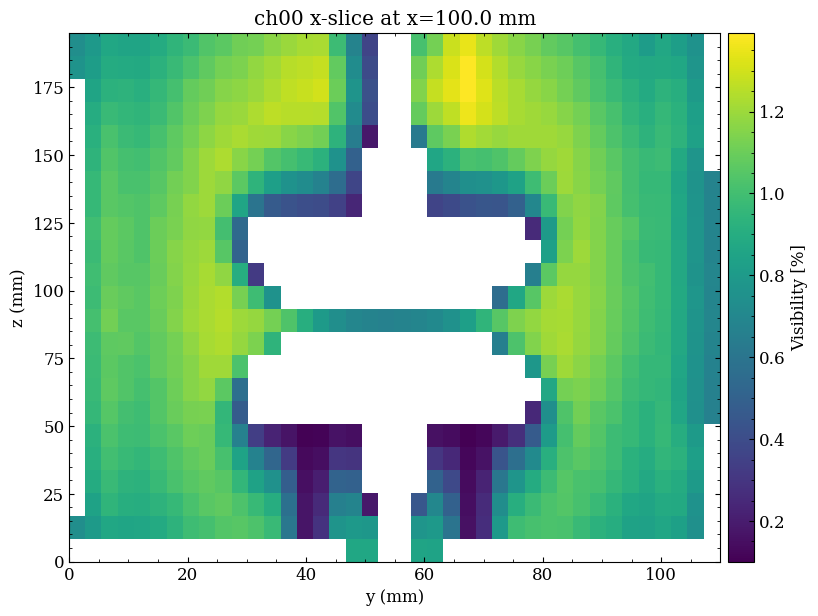

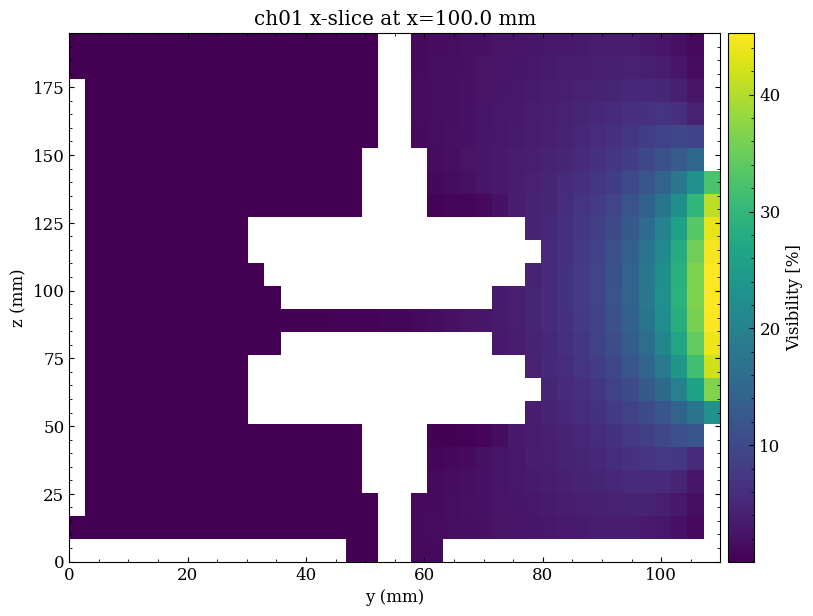

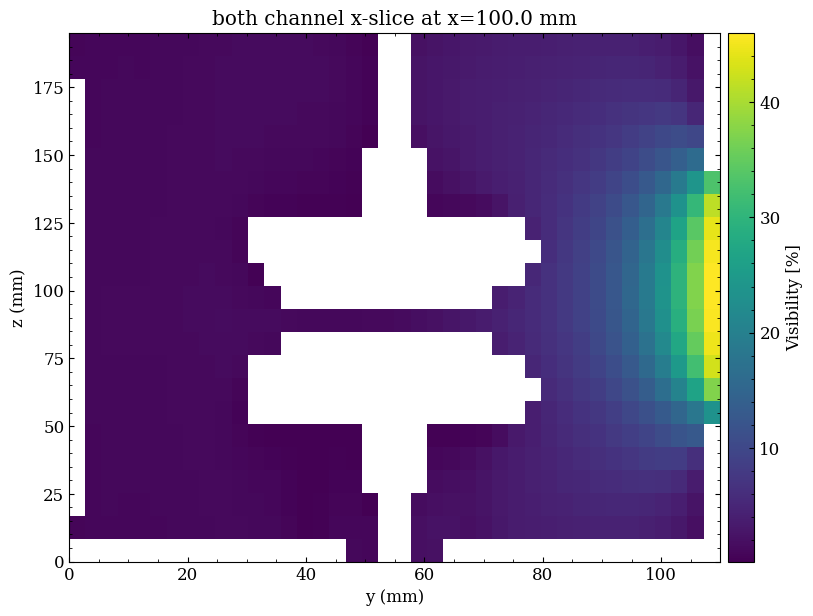

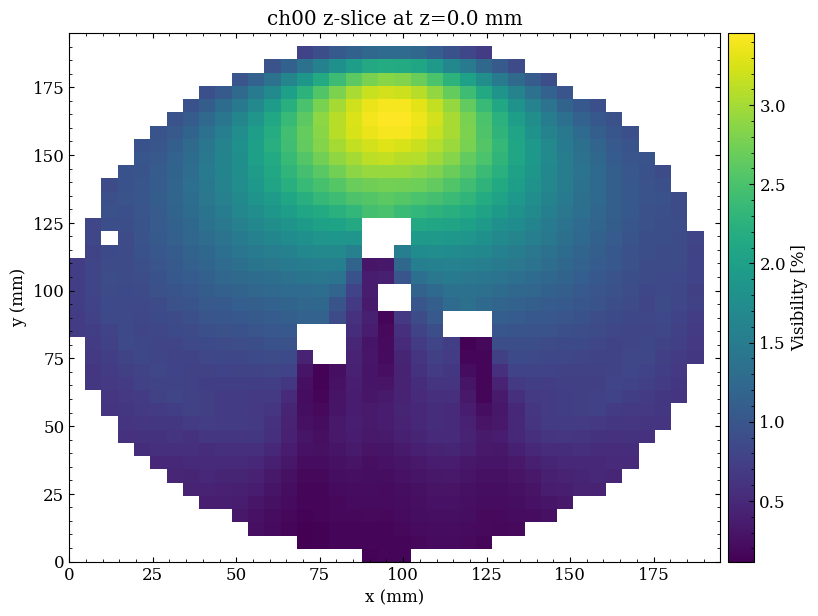

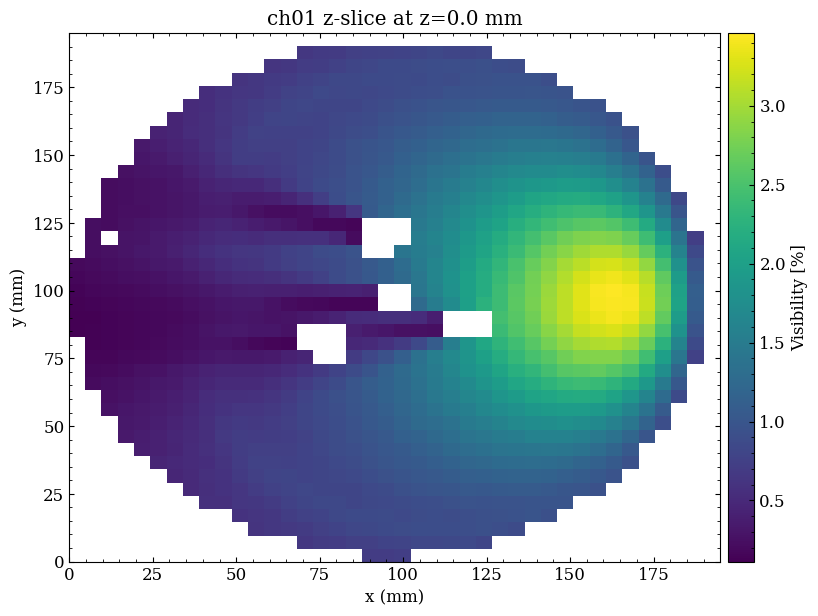

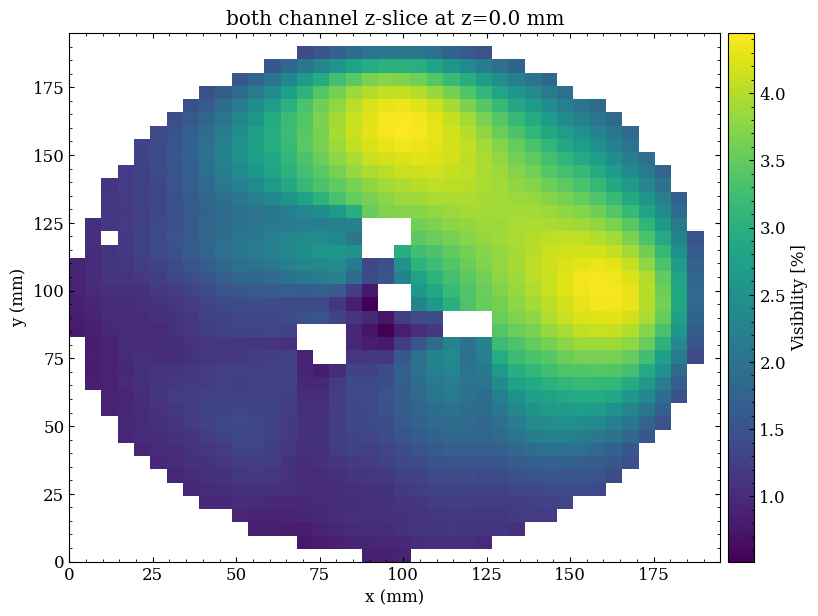

In [211]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch

max_v=t.max()
min_v=5e-4
norm=LogNorm(vmin=min_v,vmax=max_v)
norm=None

colorbarlabel="Visibility [%]"
for ch_id in range(2):
    xslice = 20
    vis = torch.clone(t[xslice, ..., ch_id])
    vis[vis <= 1e-4] = np.nan
    # get extent from plib.meta.bin_centers
    centers = plib.meta.bin_centers
    extent = [0, centers[2][-1] - centers[2][0], 0, centers[1][-1] - centers[1][0]]
    plt.imshow(vis.T, cmap="viridis", norm=norm, extent=extent, aspect="auto",)
    plt.xlabel("y (mm)")
    plt.ylabel("z (mm)")
    plt.title(f"ch{ch_id:02d} x-slice at x={centers[0][xslice]-centers[0][0]} mm")
    plt.colorbar(pad=0.01, label=colorbarlabel)
    plt.show()
xslice = 20
vis = torch.clone(t[xslice, ...].sum(axis=-1))
vis[vis <= 1e-4] = np.nan
# get extent from plib.meta.bin_centers
centers = plib.meta.bin_centers
extent = [0, centers[2][-1] - centers[2][0], 0, centers[1][-1] - centers[1][0]]
plt.imshow(vis.T, cmap="viridis", norm=norm, extent=extent, aspect="auto")
plt.xlabel("y (mm)")
plt.ylabel("z (mm)")
plt.title(f"both channel x-slice at x={centers[0][xslice]-centers[0][0]} mm")
plt.colorbar(pad=0.01, label=colorbarlabel)
plt.show()


zslice = 0
for ch_id in range(2):
    vis = torch.clone(t[..., zslice, ch_id])
    vis[vis <= 1e-4] = np.nan
    extent = [0, centers[0][-1] - centers[0][0], 0, centers[1][-1] - centers[1][0]]
    plt.imshow(vis, cmap="viridis", norm=norm, extent=extent, aspect="auto")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.title(f"ch{ch_id:02d} z-slice at z={centers[2][zslice]-centers[2][0]} mm")
    plt.colorbar(pad=0.01, label=colorbarlabel)
    plt.show()
vis = torch.clone(t[..., zslice, :].sum(axis=-1))
vis[vis <= 1e-4] = np.nan
extent = [0, centers[0][-1] - centers[0][0], 0, centers[1][-1] - centers[1][0]]
plt.imshow(vis, cmap="viridis", norm=norm, extent=extent, aspect="auto")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title(f"both channel z-slice at z={centers[2][zslice]-centers[2][0]} mm")
plt.colorbar(pad=0.01, label=colorbarlabel)
plt.show()

In [150]:
t=plib.vis
pos=plib.meta.voxel_to_coord(range(t.shape[0]))

In [152]:
pos

tensor([[130., 235., 280.],
        [135., 235., 280.],
        [140., 235., 280.],
        ...,
        [315., 430., 390.],
        [320., 430., 390.],
        [325., 430., 390.]])

In [ ]:
center_x = pos[:, 0].mean()
center_y = pos[:, 1].mean()


Text(0, 0.5, 'Visibility')

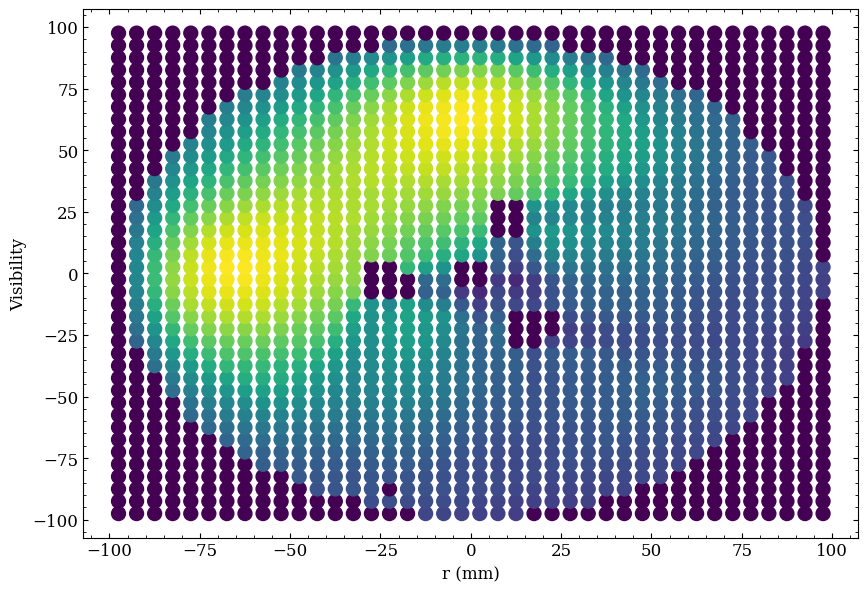

In [194]:
r = np.linalg.norm(pos[:, [0,1]] - pos[:,[0,1]].mean(axis=0), axis=1)
x = pos[:, 0].detach().cpu().numpy()
y = pos[:, 1].detach().cpu().numpy()
z = pos[:, 2].detach().cpu().numpy()

mask = z-z.min() < 5

r = r[mask]
x = x[mask]
y = y[mask]
z = z[mask]
plt.scatter(x-x.mean(), y-y.mean(), c=t[mask].mean(-1), cmap='viridis', s=100)
plt.xlabel("r (mm)")
plt.ylabel("Visibility")